# Deep learning for medical imaging

==============================================================================================
## Practicum 2: Computed Tomography Image Reconstruction
==============================================================================================

In this practicum, you will (1) simulate a simple phantom slice image, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over an slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms.  

### Aims:
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

### 2.1 Create a simple and homogeneous phantom (1.5 points)

Create a 2D simple phantom which contains a fake lesion as shown below:

<img src='images_4_notebook/SimplePhantom.png' width="200">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the lesion. Always remember to include the units of the axis when ploting a graph.

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask = np.array(mask, dtype=int)
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

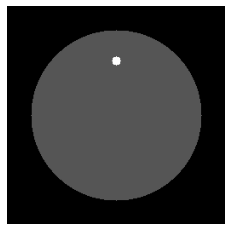

In [5]:
# insert your code here
from hashlib import new
import cv2

mask = create_circular_mask(256,256, radius=100)
mask = np.array([[128 if x == 1 else 0 for x in line] for line in mask])
mask2 = create_circular_mask(256,256, radius=5, center=[128,64])
mask2 = np.array([[256 if x == 1 else 0 for x in line] for line in mask2])
final_image = mask + mask2
plt.axis('off')
plt.imshow(final_image, cmap='gray')



### 2.2 Create the projections of the phantom (2 points)

Generate the projections of the previously generated phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following 2 approches:

``A``. Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.

``B``. Use different ranges of angles (i.e. 4º, 20º, 50º, 100º, 200º, 300º, 360º) equally distributed.  For instance, 100 projections are taken in a range of 100º.

``Questions``: What is the effect of increasing/decrasing the number of proyections? Can you comment on the difference between approach A and B?

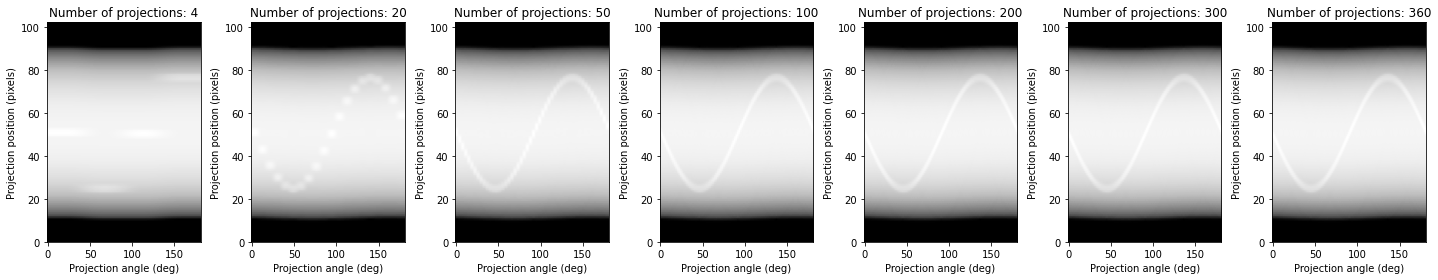

In [6]:
from skimage.transform import radon, rescale

################################################
#                 APPROACH A                   #
################################################

image = rescale(final_image, scale=0.4, mode='reflect', channel_axis=None)
sinogramsA = []
number_projections = [4,20,50,100,200,300,360]
fig, ax = plt.subplots(1, len(number_projections), figsize=(20, 4))
# plot the sinogram for different number of projections
for i in number_projections:
    sinogram = radon(image, theta=np.linspace(0., 360., i, endpoint=False))
    sinogramsA.append(sinogram)
    ax[number_projections.index(i)].imshow(sinogram, cmap='gray')
    ax[number_projections.index(i)].set_title('Number of projections: {}'.format(i))
    ax[number_projections.index(i)].set_xlabel('Projection angle (deg)')
    ax[number_projections.index(i)].set_ylabel('Projection position (pixels)')
    #ax[number_projections.index(i)].imshow()
    dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
    ax[number_projections.index(i)].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()


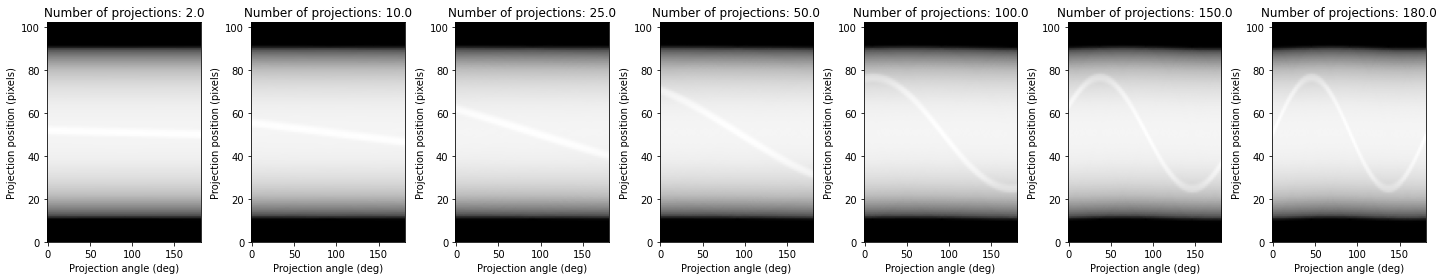

In [7]:
################################################
#                 APPROACH B                   #
################################################

image = rescale(final_image, scale=0.4, mode='reflect', channel_axis=None)
sinogramsB = []
number_angles = [2.,10.,25.,50.,100.,150.,180.]
fig, ax = plt.subplots(1, len(number_angles), figsize=(20, 4))
# plot the sinogram for different number of projections
for i in number_angles:
    sinogram = radon(image, theta=np.linspace(i*-1., i, 100, endpoint=False))
    sinogramsB.append(sinogram)
    ax[number_angles.index(i)].imshow(sinogram, cmap='gray')
    ax[number_angles.index(i)].set_title('Number of projections: {}'.format(i))
    ax[number_angles.index(i)].set_xlabel('Projection angle (deg)')
    ax[number_angles.index(i)].set_ylabel('Projection position (pixels)')
    #ax[number_projections.index(i)].imshow()
    dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
    ax[number_angles.index(i)].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

### 2.3 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Then, show the original and reconstructed images of the phantom.

Explore the two approches (A and B) described previously.

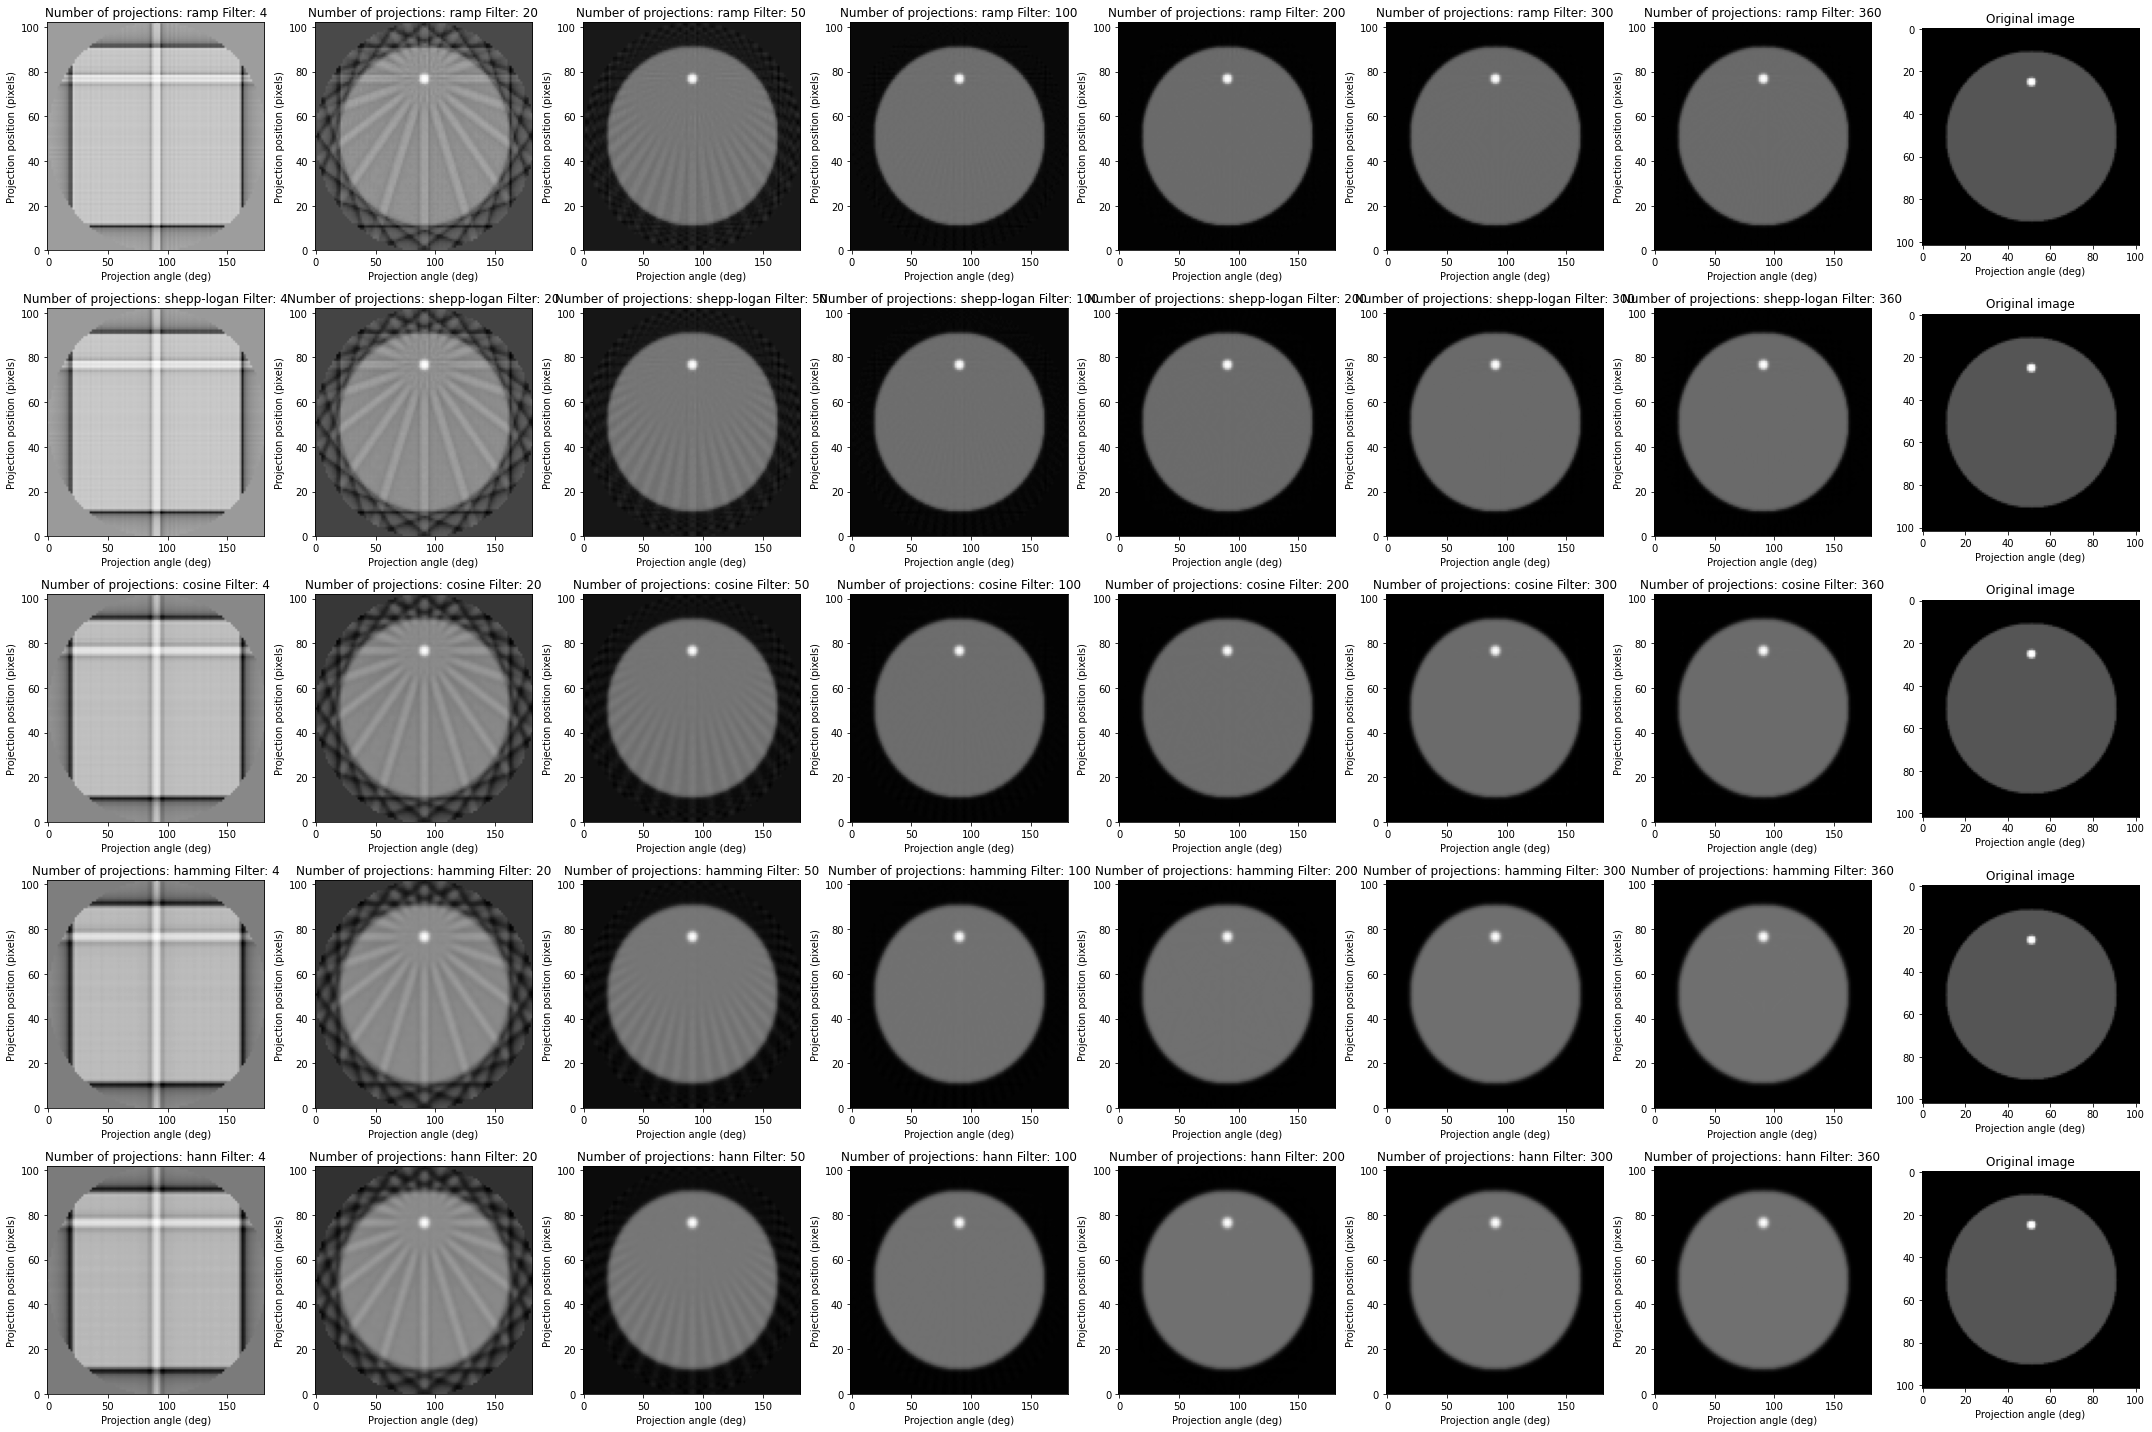

In [8]:
# insert your code here
from skimage.transform import iradon
# apply filters to image using iradon Shepp-logan, Cosine, Hamming, Hann
################################################
#                 APPROACH A                   #
################################################
reconstructed_imagesA = []
number_projections = [4,20,50,100,200,300,360]
filter_names = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
# make a plot of the reconstructed images 5x8
fig, ax = plt.subplots(5, 8, figsize=(30, 20))
for i in filter_names:
    for j in number_projections:
        reconstruction_fbp = iradon(sinogramsA[number_projections.index(j)], theta=np.linspace(0., 360., j, endpoint=False), filter_name=i)
        ax[filter_names.index(i), number_projections.index(j)].set_title('Number of projections: {} Filter: {}'.format(i,j))
        ax[filter_names.index(i), number_projections.index(j)].set_xlabel('Projection angle (deg)')
        ax[filter_names.index(i), number_projections.index(j)].imshow(reconstruction_fbp, cmap='gray')
        ax[filter_names.index(i), number_projections.index(j)].set_ylabel('Projection position (pixels)')
        dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
        ax[filter_names.index(i), number_projections.index(j)].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
        if j == 360:
            reconstructed_imagesA.append(reconstruction_fbp)
        
    ax[filter_names.index(i), -1].set_title('Original image')
    ax[filter_names.index(i), -1].set_xlabel('Projection angle (deg)')
    ax[filter_names.index(i), -1].imshow(image, cmap='gray')

fig.tight_layout()
plt.show()

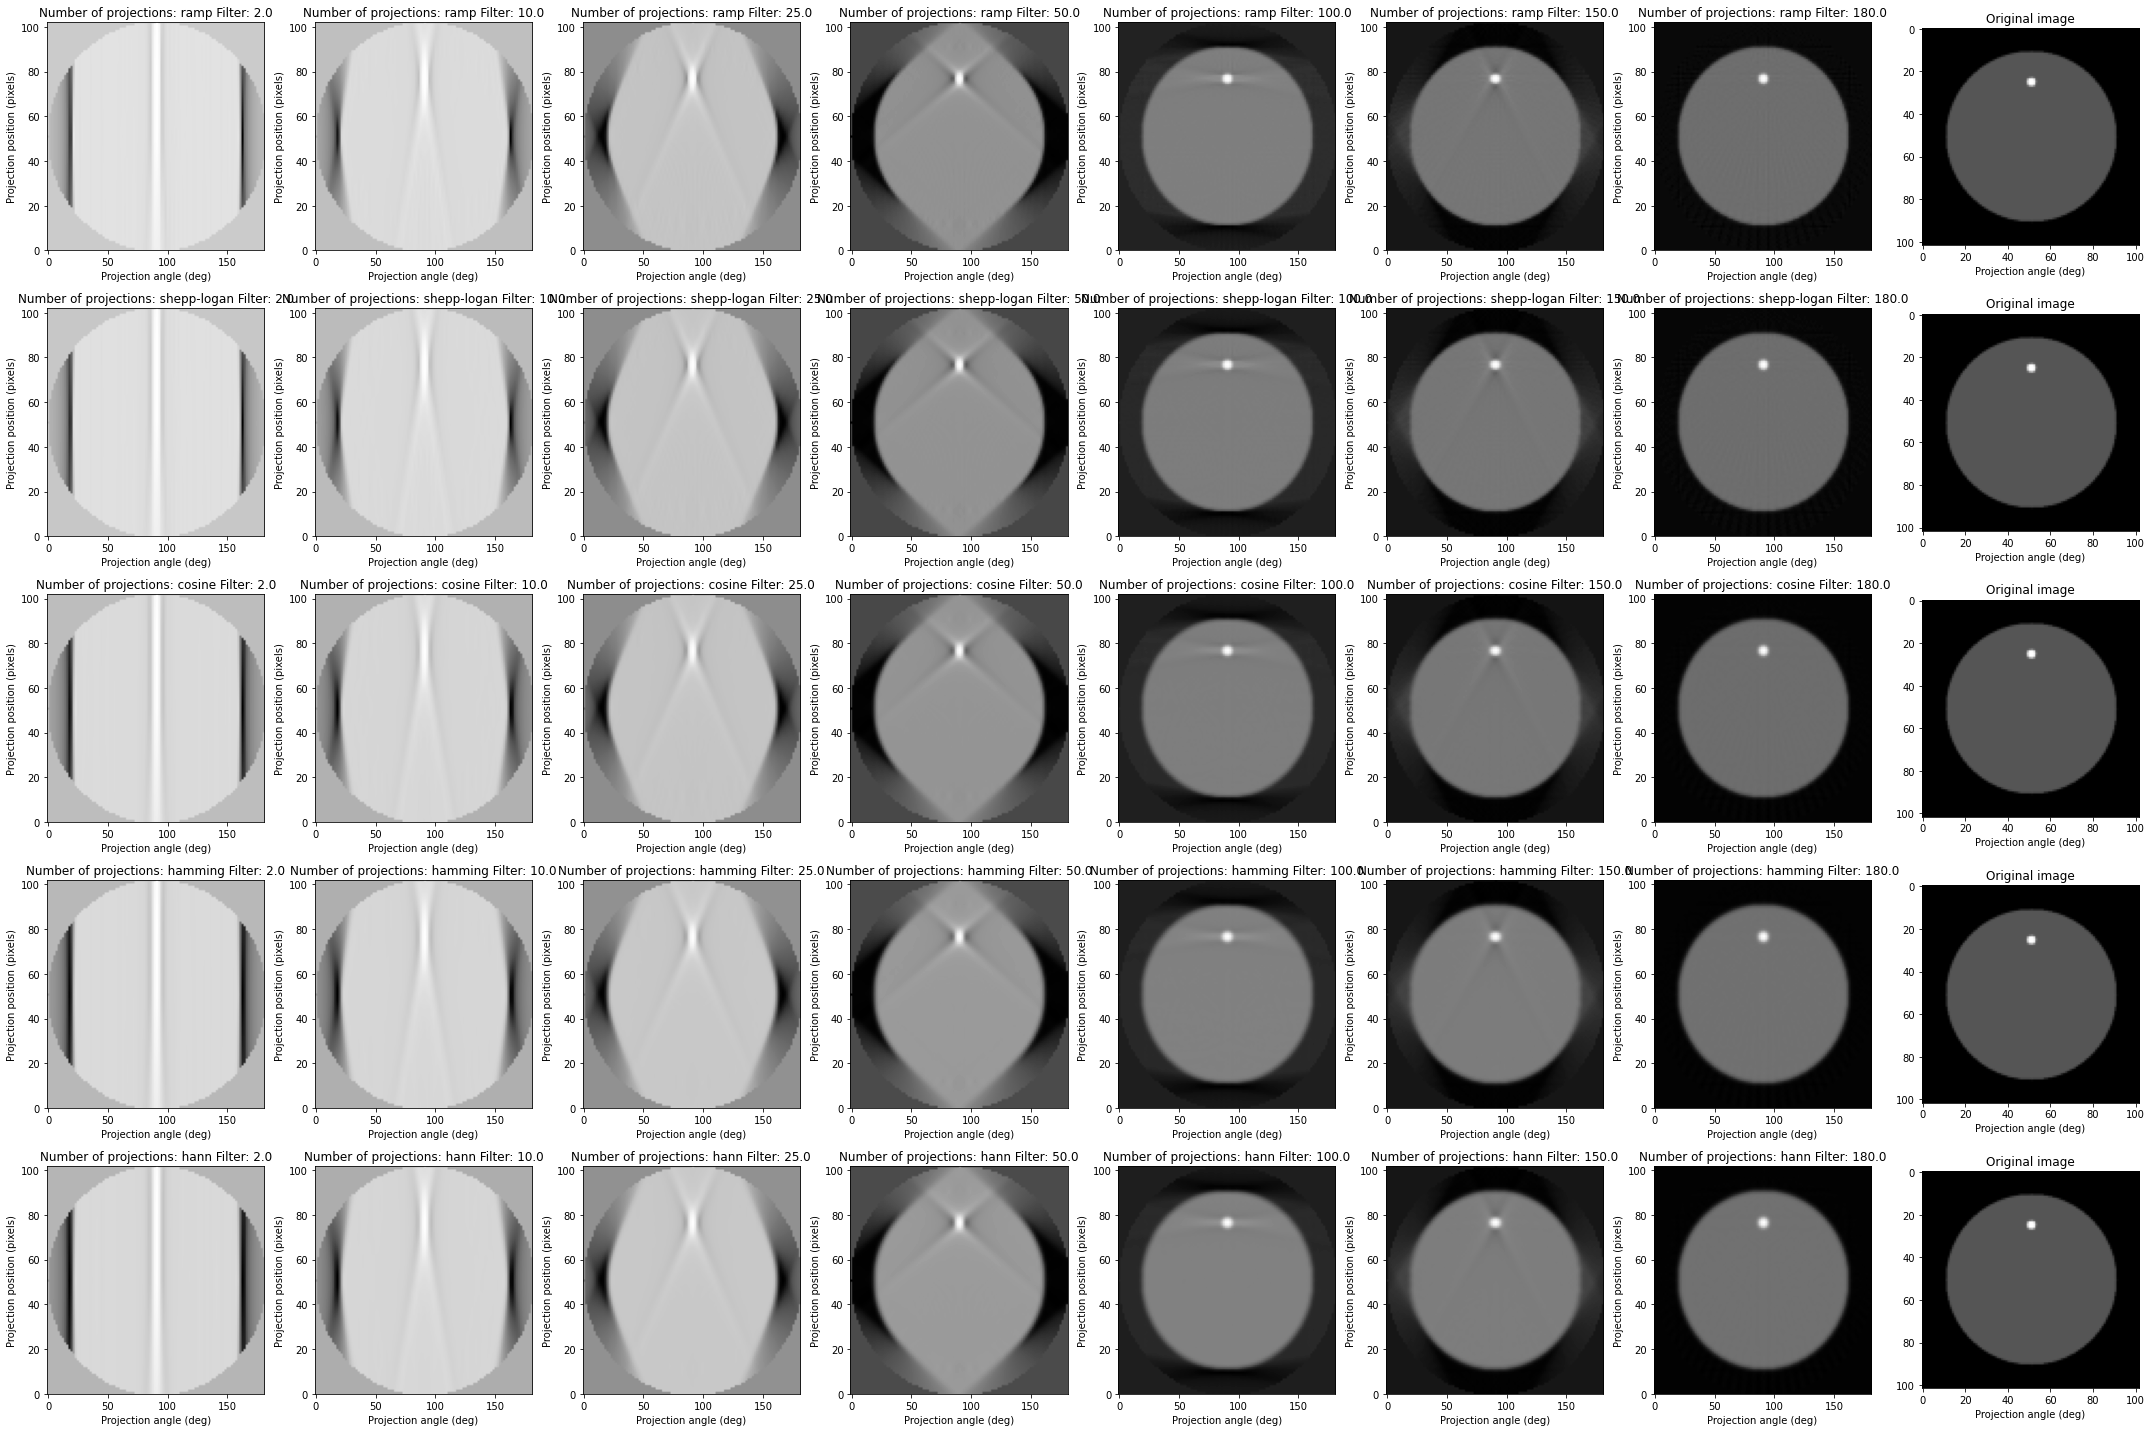

In [9]:
################################################
#                 APPROACH B                   #
################################################
number_angles = [2.,10.,25.,50.,100.,150.,180.]
filter_names = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
reconstructed_imagesB = []
# make a plot of the reconstructed images 5x8
fig, ax = plt.subplots(5, 8, figsize=(30, 20))
for i in filter_names:
    for j in number_angles:
        reconstruction_fbp = iradon(sinogramsB[number_angles.index(j)], theta=np.linspace(j*-1, j, 100, endpoint=False), filter_name=i)
        ax[filter_names.index(i), number_angles.index(j)].set_title('Number of projections: {} Filter: {}'.format(i,j))
        ax[filter_names.index(i), number_angles.index(j)].set_xlabel('Projection angle (deg)')
        ax[filter_names.index(i), number_angles.index(j)].imshow(reconstruction_fbp, cmap='gray')
        ax[filter_names.index(i), number_angles.index(j)].set_ylabel('Projection position (pixels)')
        dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
        ax[filter_names.index(i), number_angles.index(j)].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
        if number_angles.index(j) == 6:
            reconstructed_imagesB.append(reconstruction_fbp)
            
    ax[filter_names.index(i), -1].set_title('Original image')
    ax[filter_names.index(i), -1].set_xlabel('Projection angle (deg)')
    ax[filter_names.index(i), -1].imshow(image, cmap='gray')

fig.tight_layout()
plt.show()

### 2.4 Compare the reconstructed signals (1 points)

Make use of the ``matplotlib`` to compare the original and reconstructed signals. In order to do so, make a single plot with the different pixel intensity profiles of the lesion (as done in 2.1). Then, discuss the results.

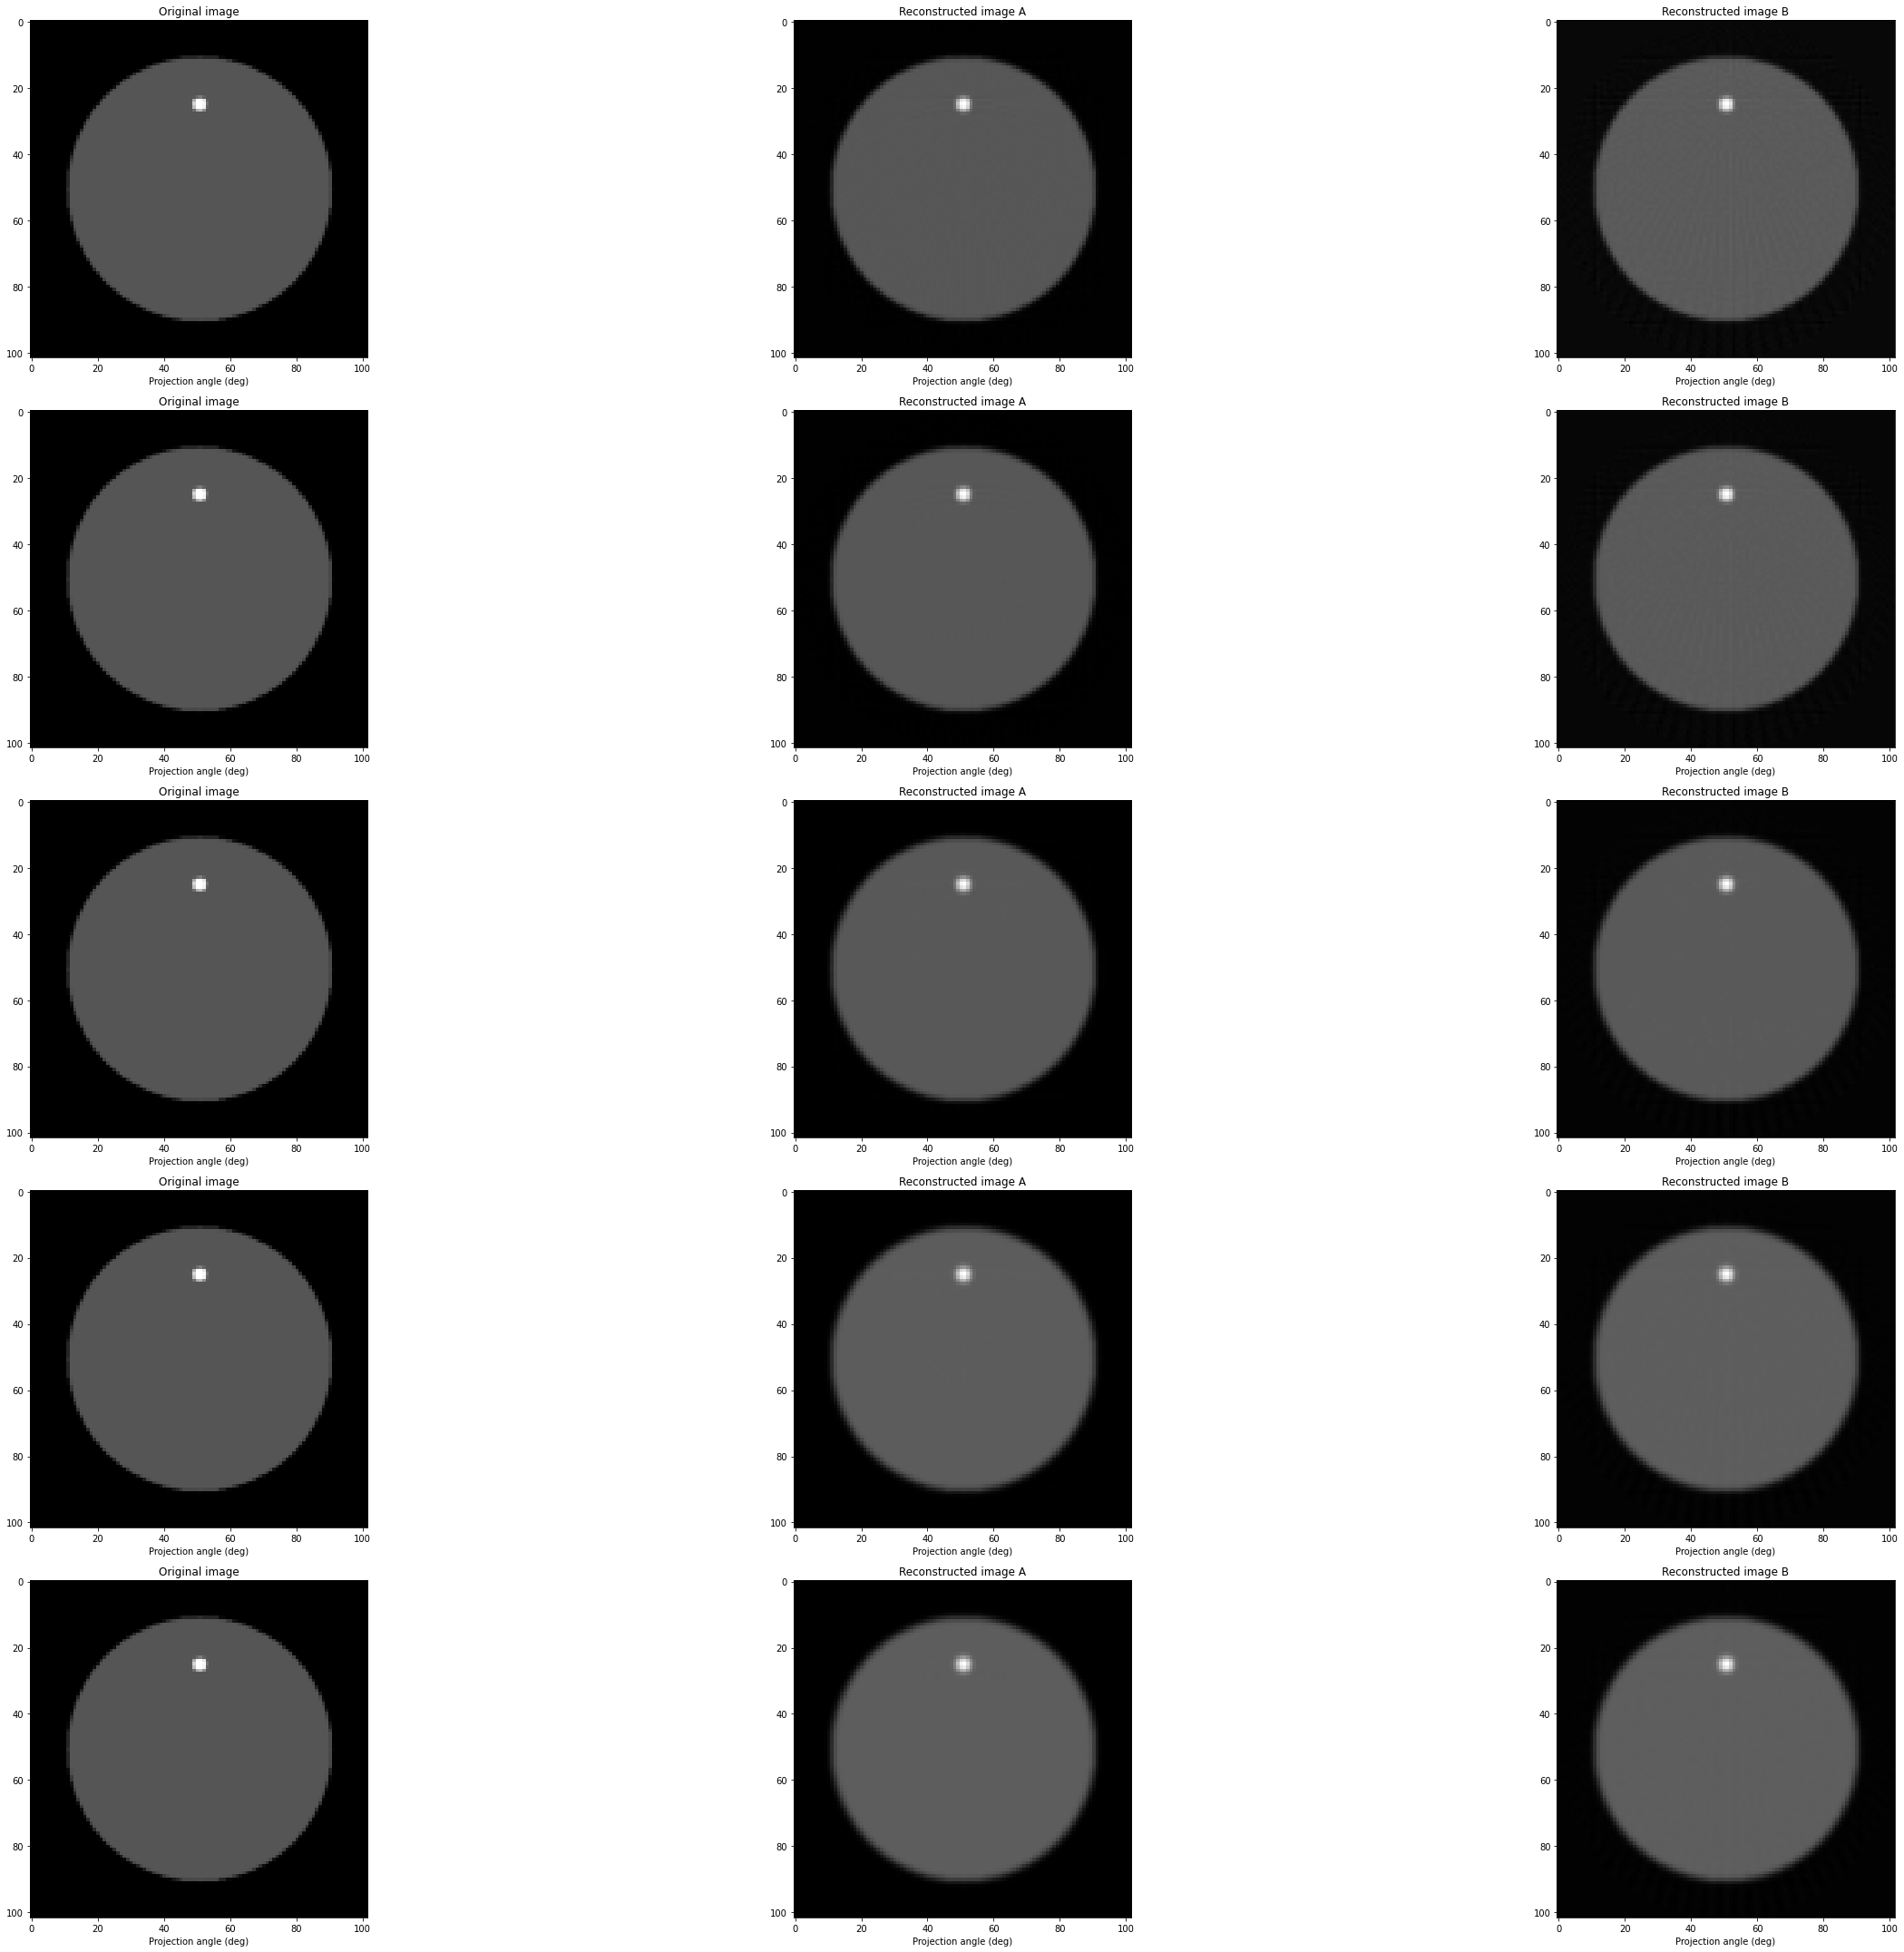

In [10]:
# a plot of the reconstructed images A and B and original image in grid 5x3
fig, ax = plt.subplots(5, 3, figsize=(40, 30))
for i in range(5):
    ax[i, 0].set_title('Original image')
    ax[i, 0].set_xlabel('Projection angle (deg)')
    ax[i, 0].imshow(image, cmap='gray')
    ax[i, 1].set_title('Reconstructed image A')
    ax[i, 1].set_xlabel('Projection angle (deg)')
    ax[i, 1].imshow(reconstructed_imagesA[i], cmap='gray')
    ax[i, 2].set_title('Reconstructed image B')
    ax[i, 2].set_xlabel('Projection angle (deg)')
    ax[i, 2].imshow(reconstructed_imagesB[i], cmap='gray')

fig.tight_layout()
plt.show()





We can observe how the reconstruccion images are so similar and it's difficult to observe the difference between them. However, if we compare the pixel intensity profiles of the lesion, we can observe that the reconstructed images are not the same. The reconstructed images are not the same because the sinograms are not the same. The sinograms are not the same because the number of projections and the range of angles are different. So we have an image with less quality.

### 2.5 Reconstructing noisy sinograms (2 points)

Add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your previous sinograms and reconstruct the phantom images with the different filters. Plot the reconstruction image and the intensity profile along the lession. Then, comment on the effects of the filters on the reconstructed phatom images.

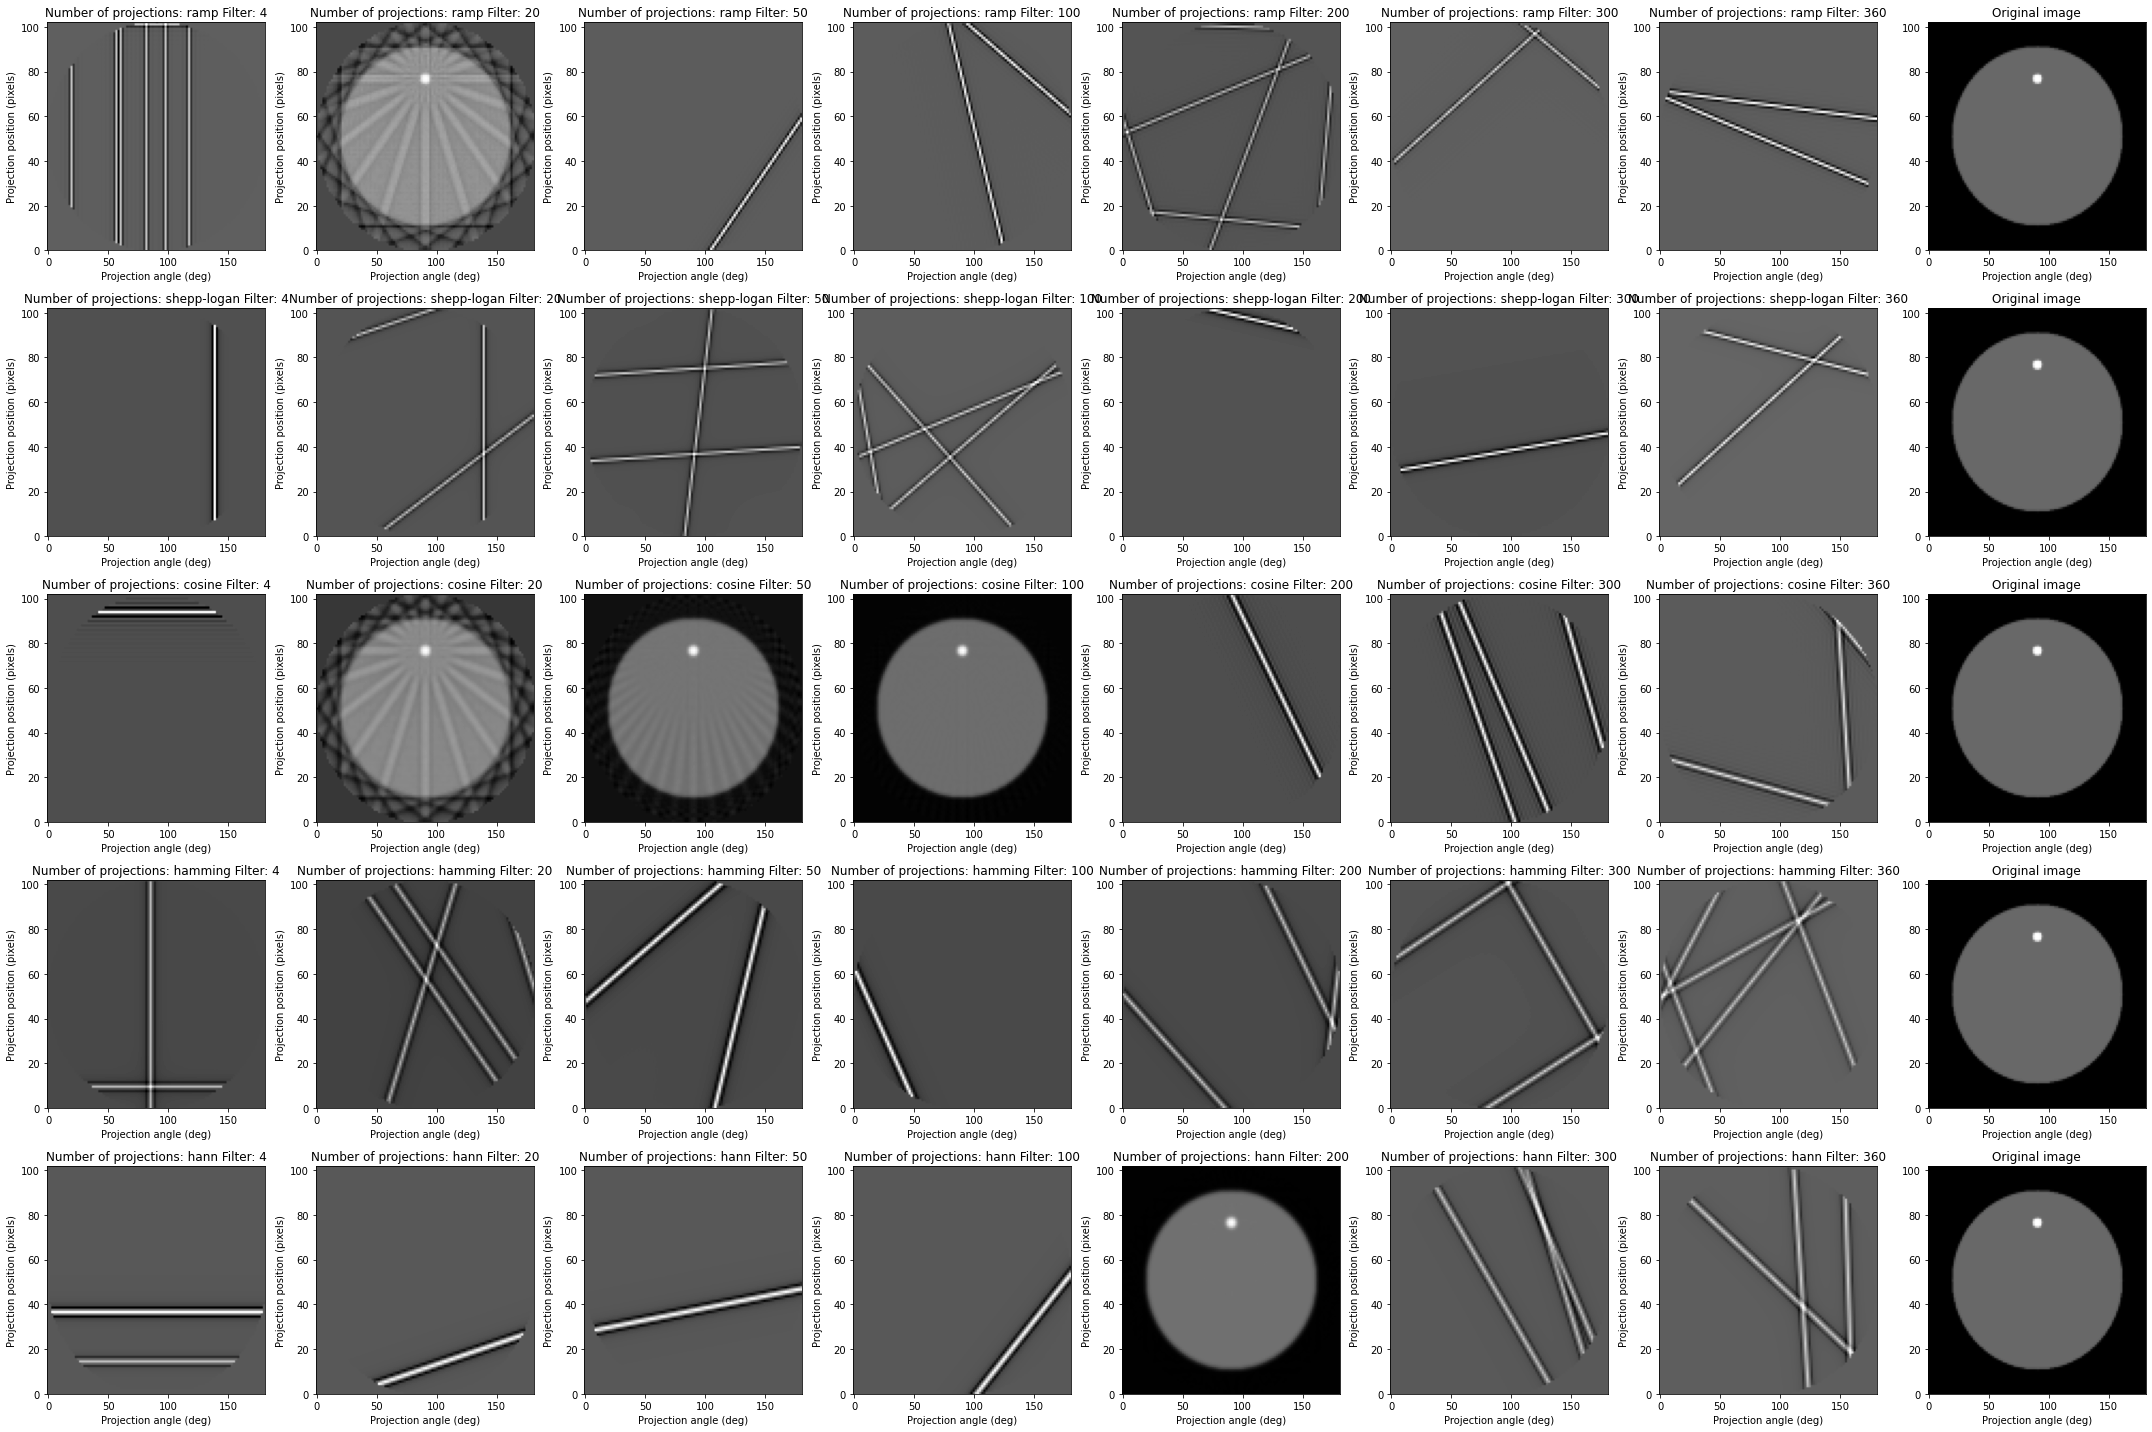

In [19]:
################################################
#                 APPROACH A                   #
################################################
from sklearn.preprocessing import normalize

number_projections = [4,20,50,100,200,300,360]
filter_names = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
# make a plot of the reconstructed images 5x8
fig, ax = plt.subplots(5, 8, figsize=(30, 20))
for i in filter_names:
    for j in number_projections:
        random_noise = np.random.poisson(lam=1/np.argmax(sinogramsA[number_projections.index(j)]), size=sinogramsA[number_projections.index(j)].shape)
        sinogram = (sinogramsA[number_projections.index(j)]/np.argmax(sinogramsA[number_projections.index(j)]) + random_noise)
        #sinogram = sinogram/np.argmax(sinogram)
        reconstruction_fbp = iradon(sinogram, theta=np.linspace(0., 360., j, endpoint=False), filter_name=i)
        ax[filter_names.index(i), number_projections.index(j)].set_title('Number of projections: {} Filter: {}'.format(i,j))
        ax[filter_names.index(i), number_projections.index(j)].set_xlabel('Projection angle (deg)')
        ax[filter_names.index(i), number_projections.index(j)].imshow(reconstruction_fbp, cmap='gray')
        ax[filter_names.index(i), number_projections.index(j)].set_ylabel('Projection position (pixels)')
        dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
        ax[filter_names.index(i), number_projections.index(j)].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
        
    ax[filter_names.index(i), -1].set_title('Original image')
    ax[filter_names.index(i), -1].set_xlabel('Projection angle (deg)')
    ax[filter_names.index(i), -1].imshow(image, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

# add random noise np.random.poisson to sinogram and plot it




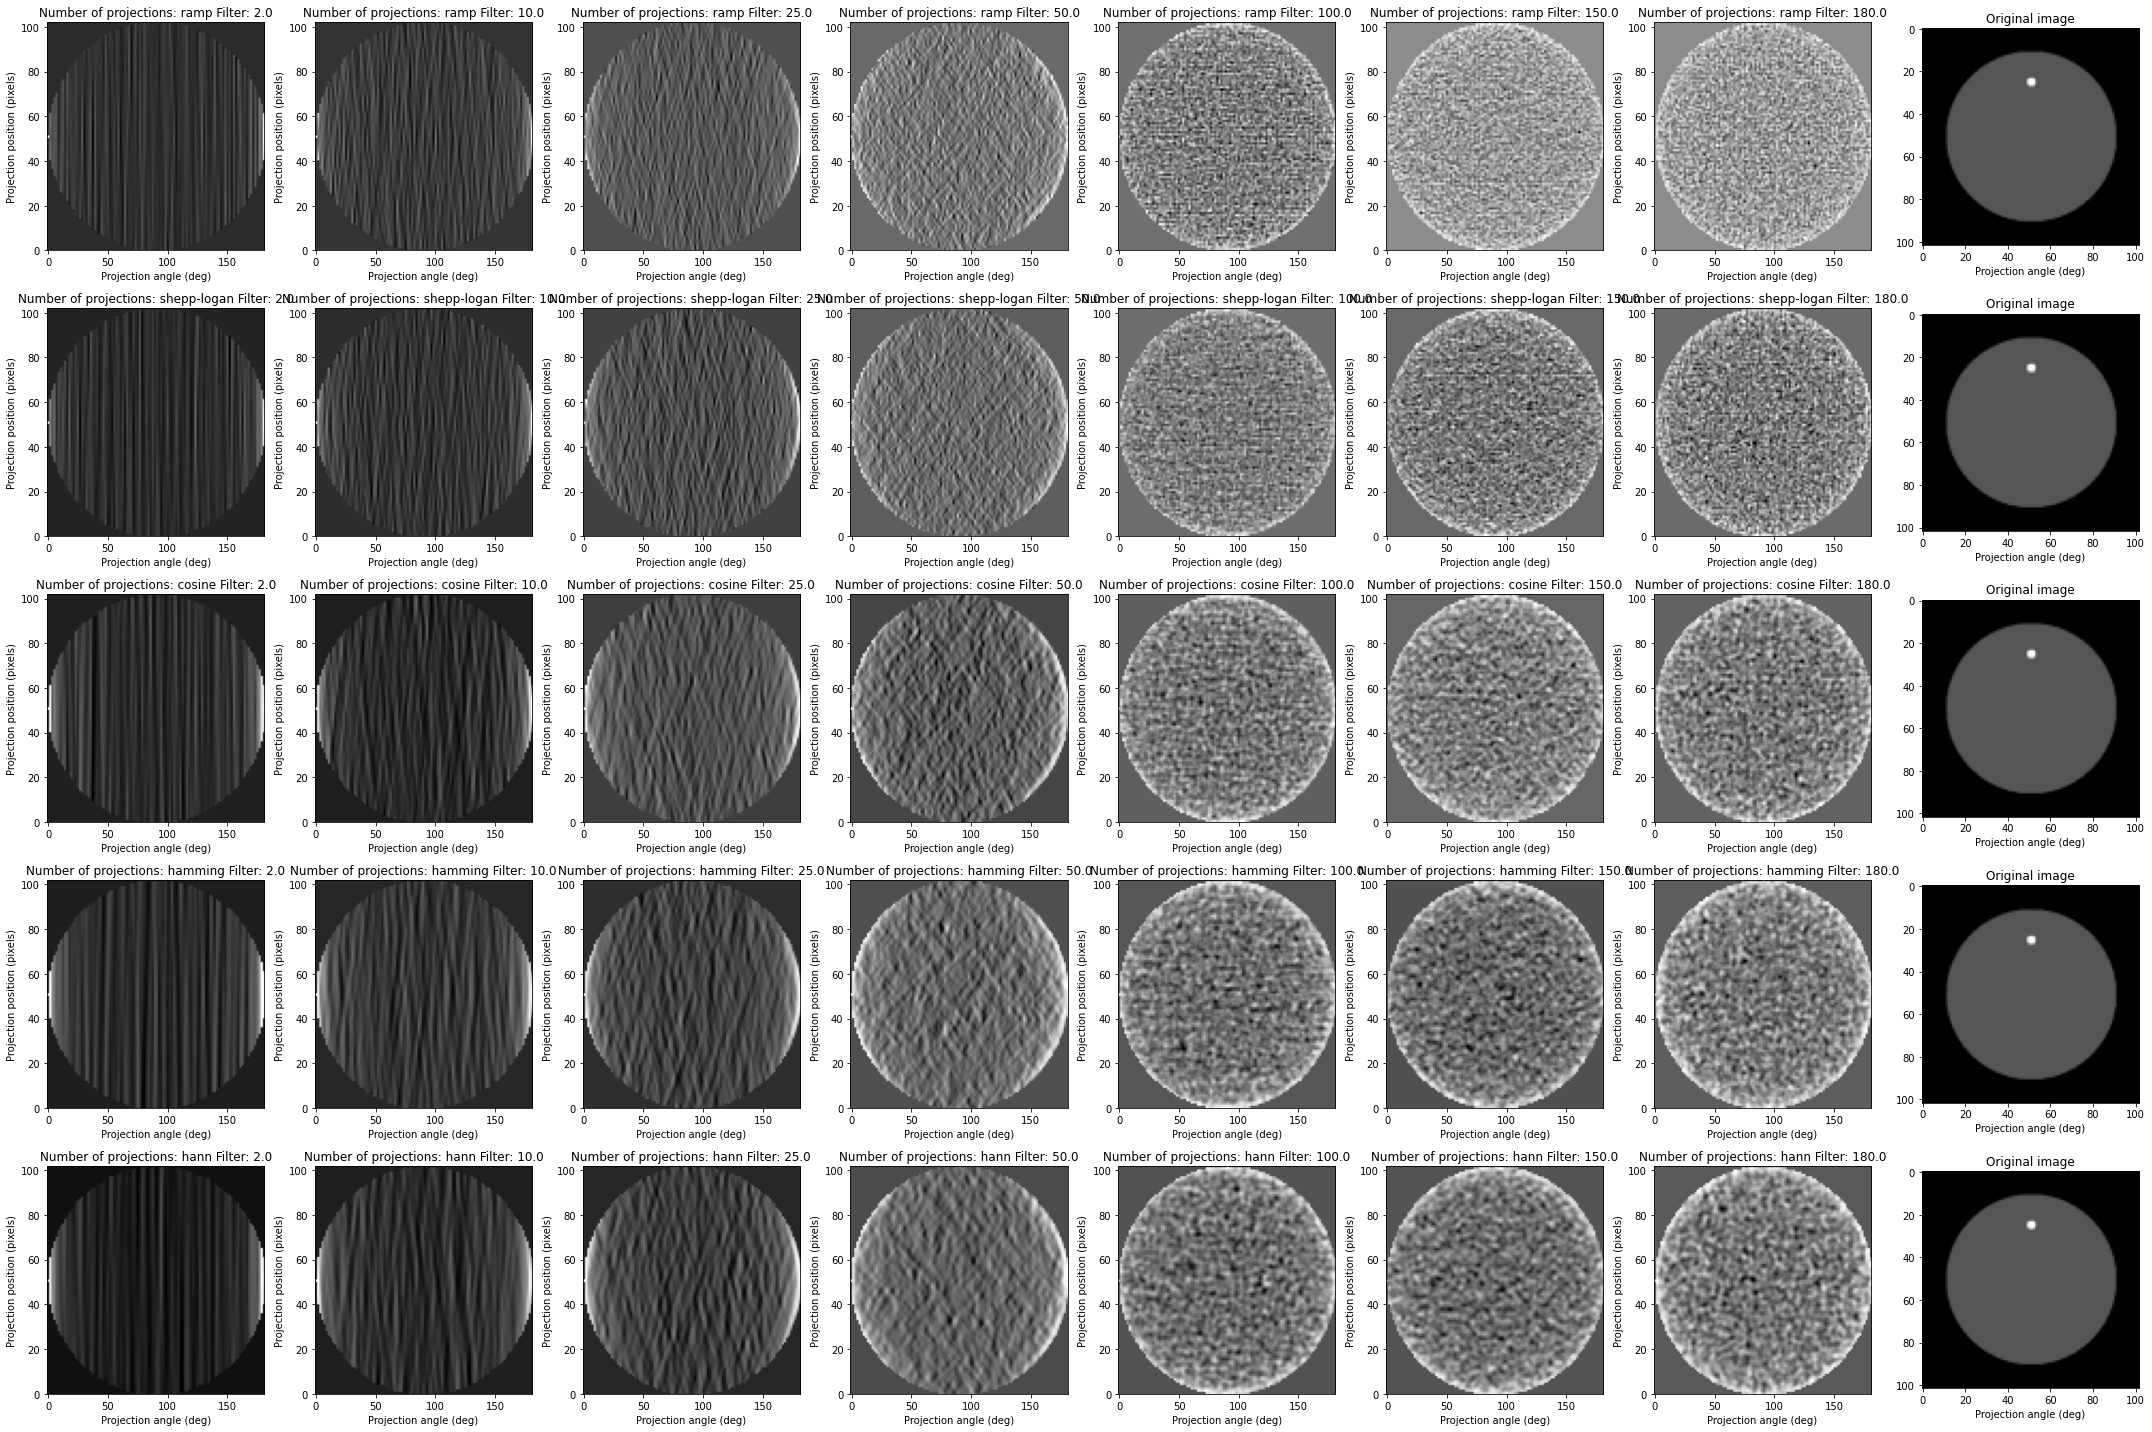

In [75]:
################################################
#                 APPROACH B                   #
################################################
number_angles = [2.,10.,25.,50.,100.,150.,180.]
filter_names = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

# make a plot of the reconstructed images 5x8
fig, ax = plt.subplots(5, 8, figsize=(30, 20))
for i in filter_names:
    for j in number_angles:
        random_noise = np.random.poisson(lam=10, size=sinogramsB[number_angles.index(j)].shape)
        sinogram = sinogramsB[number_angles.index(j)] + random_noise
        reconstruction_fbp = iradon(sinogram, theta=np.linspace(j*-1, j, 100, endpoint=False), filter_name=i)
        ax[filter_names.index(i), number_angles.index(j)].set_title('Number of projections: {} Filter: {}'.format(i,j))
        ax[filter_names.index(i), number_angles.index(j)].set_xlabel('Projection angle (deg)')
        ax[filter_names.index(i), number_angles.index(j)].imshow(reconstruction_fbp, cmap='gray')
        ax[filter_names.index(i), number_angles.index(j)].set_ylabel('Projection position (pixels)')
        dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
        ax[filter_names.index(i), number_angles.index(j)].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
     
    ax[filter_names.index(i), -1].set_title('Original image')
    ax[filter_names.index(i), -1].set_xlabel('Projection angle (deg)')
    ax[filter_names.index(i), -1].imshow(image, cmap='gray')

fig.tight_layout()
plt.show()

Watching the two approaches the conclusion is clear. Adding random noise it's hard and difficult to reconstruct the image. Approach A gives better results than approach B. The filter that gives better results is the han filter with 360 number of projections.

### 2.6 Sheep logan phantom (1 point)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms? 


In [6]:
from skimage.data import shepp_logan_phantom

image = shepp_logan_phantom()

# insert your code here